In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# Downloading CIFAR-10
import numpy as np
import os
import requests
import tarfile
import pickle

# Model definition
from dl import Module
from dl.modules import Convolution, ReLU, Linear, Flatten, MaxPool

# Training
from dl import Variable
from dl.data import BatchLoader, train_val_split, ComposeTransforms
from dl.optimizers import SGD, LRScheduler
from dl.functions import cross_entropy_loss

# Output
from tqdm import tqdm
import matplotlib.pyplot as plt

## Download and extract CIFAR-10.

In [23]:
root = './data'
url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = 'cifar-10-python.tar.gz'
archive_path = os.path.join(root, filename)
extract_path = os.path.join(root, 'cifar-10-batches-py')

os.makedirs(root, exist_ok=True)

# Download compressed file containing dataset.
if not os.path.exists(archive_path):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(archive_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)

# Extract dataset from compressed file.
if not os.path.exists(extract_path):
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=os.path.dirname(extract_path))

print(f"\nCIFAR-10 is ready at: {extract_path}")


CIFAR-10 is ready at: ./data/cifar-10-batches-py


## Load CIFAR-10 into ram.

In [24]:
def load_cifar_batch(batch_path):
    with open(batch_path, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
        X = batch[b'data'] # shape (10000, 3072)
        X = X.reshape(-1, 3, 32, 32).astype(np.float32)
        y = np.array(batch[b'labels']) # list of 10000 ints

    return X, y

# Iterate over all 5 batch files.
xs = []
ys = []
for i in range(1, 6): 
    batch_path = os.path.join(extract_path, f'data_batch_{i}')
    with open(batch_path, 'rb') as fo:
        X, y = load_cifar_batch(batch_path)

    xs.append(X)
    ys.append(y)

X_train_full = np.concatenate(xs)  # shape (50000, 3, 32, 32)
y_train_full = np.concatenate(ys)
X_test, y_test = load_cifar_batch(os.path.join(extract_path, 'test_batch'))

# Set aside a validation set.
X_train, y_train, X_val, y_val = train_val_split(X_train_full, y_train_full, ratio=0.1, seed=42)

## Define Transforms and Augmentations.

In [25]:
# Compute normalization statistics.
X_for_stats = X_train.astype(np.float32) / 255.0
mean = np.mean(X_for_stats, axis=(0, 2, 3))
std = np.std(X_for_stats, axis=(0, 2, 3))

class ToFloat:

    def __call__(self, X):
        return X.astype(np.float32) / 255.0

class ToVariable:

    def __call__(self, X):
        return Variable(X)

class Normalize:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, X):
        return (X - self.mean[:, None, None]) / self.std[:, None, None]

class RandomHorizontalFlip:

    def __init__(self, p):
        self.p = p

    def __call__(self, X):

        if np.random.rand() < self.p:
            X = np.flip(X, axis=2).copy()

        return X

class RandomCrop:

    def __init__(self, image_size, padding=2):
        self.image_size = image_size
        self.padding = padding

    def __call__(self, X):
        X = np.pad(
            X,
            ((0, 0), (self.padding, self.padding), (self.padding, self.padding)),
            mode="constant",
        )
        left = np.random.randint(0, 2 * self.padding)
        top = np.random.randint(0, 2 * self.padding)

        return X[:, top : top + self.image_size, left : left + self.image_size].copy()

train_image_transforms = ComposeTransforms([RandomCrop(32), RandomHorizontalFlip(0.5), ToFloat(), Normalize(mean, std), ToVariable()])
val_image_transforms = ComposeTransforms([ToFloat(), Normalize(mean, std), ToVariable()])
label_transforms = ToVariable()


## Create BatchLoaders.

In [26]:
class Cifar10:
    
    def __init__(self, images, labels, image_transforms=None, label_transforms=None):
        super().__init__()
        
        self.images = images
        self.labels = labels
        self.image_transforms = image_transforms
        self.label_transforms = label_transforms
        
    def __getitem__(self, idx):
        
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.image_transforms is not None:
            image = self.image_transforms(image)
        
        if self.label_transforms is not None:
            label = self.label_transforms(label)
            
        return image, label
        
    def __len__(self):
        return self.images.shape[0]

In [27]:
batchloaders = {}
batchloaders['train'] = BatchLoader(Cifar10(X_train, y_train, train_image_transforms, label_transforms), batch_size=128, shuffle=True)
batchloaders['val'] = BatchLoader(Cifar10(X_val, y_val, val_image_transforms, label_transforms), batch_size=128, shuffle=False)
batchloaders['test'] = BatchLoader(Cifar10(X_test, y_test, val_image_transforms, label_transforms), batch_size=128, shuffle=False)

## Define the CNN architecture.

In [28]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        
        # Conv Block 1
        self.conv1 = Convolution(C_in=3, C_out=32, K=3, stride=1, padding=1)
        self.relu1 = ReLU()
        self.pool1 = MaxPool(K=2, stride=2)  # 32x32 → 16x16

        # Conv Block 2
        self.conv2 = Convolution(C_in=32, C_out=64, K=3, stride=1, padding=1)
        self.relu2 = ReLU()
        self.pool2 = MaxPool(K=2, stride=2)  # 16x16 → 8x8

        # Conv Block 3
        self.conv3 = Convolution(C_in=64, C_out=128, K=3, stride=1, padding=1)
        self.relu3 = ReLU()
        self.pool3 = MaxPool(K=2, stride=2)  # 8x8 → 4x4

        self.flat = Flatten()
        self.fc1 = Linear(128 * 4 * 4, 256)
        self.relu4 = ReLU()
        self.fc2 = Linear(256, 10)  # CIFAR-10 output

    def forward(self, X):
        X = self.pool1(self.relu1(self.conv1(X)))
        X = self.pool2(self.relu2(self.conv2(X)))
        X = self.pool3(self.relu3(self.conv3(X)))
        X = self.flat(X)
        X = self.relu4(self.fc1(X))
        X = self.fc2(X)
        return X

## Train the CNN.

In [29]:
learning_rate_schedule = {0: 0.01, 30: 0.001, 60: 0.0001}

model = CNN()
optimizer = SGD(model.parameters(), momentum=0.9)
scheduler = LRScheduler(optimizer, learning_rate_schedule)

In [30]:
epochs = 2
training_losses = []
validation_losses = []

for epoch in range(epochs):
    
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Train
    
    train_loss = 0
    model.enable_grad()
    pbar = tqdm(batchloaders['train'], desc="Training", leave=False)
    for X_batch, y_batch in pbar:
        
        # Compute features and loss.
        features = model(X_batch)
        loss = cross_entropy_loss(features, y_batch)
       
        # Update model parameters.
        optimizer.clear_grad()
        loss.backward()
        optimizer.update_parameters()
    
        train_loss += loss.data
        # Update tqdm bar with batch loss
        pbar.set_postfix(loss=loss.data)
        
    training_losses.append(train_loss / len(batchloaders['train']))
    scheduler.step()
    
    # Validate
    
    val_loss = 0
    model.disable_grad()
    for X_batch, y_batch in tqdm(batchloaders['test'], desc="Validating", leave=False):
        
        features = model(X_batch)
        loss = cross_entropy_loss(features, y_batch)
        
        val_loss += loss.data
    
    validation_losses.append(val_loss / len(batchloaders['val']))
    print(f"Train Loss: {training_losses[-1]:.4f} | Val Loss: {validation_losses[-1]:.4f}")


Epoch 1/2


Train Loss: 1.6894 | Val Loss: 2.5541

Epoch 2/2


Train Loss: 1.2619 | Val Loss: 2.2605


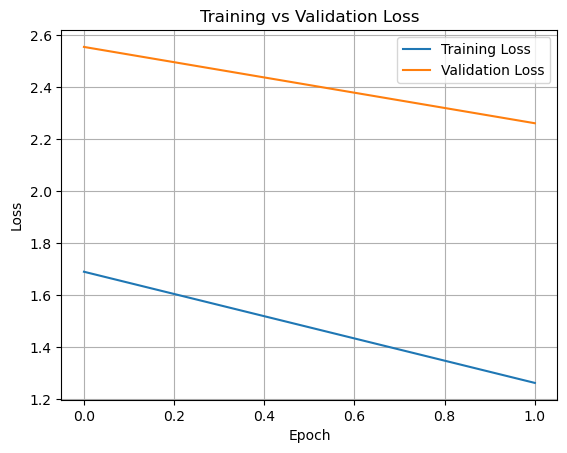

In [31]:
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()